In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/ARCS/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS


In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd
import scipy

In [3]:
%matplotlib notebook

In [5]:
# ls /SNS/ARCS/IPTS-21387/nexus/

In [6]:
RunNumbers=range(107970,108193)
print(RunNumbers)
IPTS=21387
datadir="/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/autoreduce/"

[107970, 107971, 107972, 107973, 107974, 107975, 107976, 107977, 107978, 107979, 107980, 107981, 107982, 107983, 107984, 107985, 107986, 107987, 107988, 107989, 107990, 107991, 107992, 107993, 107994, 107995, 107996, 107997, 107998, 107999, 108000, 108001, 108002, 108003, 108004, 108005, 108006, 108007, 108008, 108009, 108010, 108011, 108012, 108013, 108014, 108015, 108016, 108017, 108018, 108019, 108020, 108021, 108022, 108023, 108024, 108025, 108026, 108027, 108028, 108029, 108030, 108031, 108032, 108033, 108034, 108035, 108036, 108037, 108038, 108039, 108040, 108041, 108042, 108043, 108044, 108045, 108046, 108047, 108048, 108049, 108050, 108051, 108052, 108053, 108054, 108055, 108056, 108057, 108058, 108059, 108060, 108061, 108062, 108063, 108064, 108065, 108066, 108067, 108068, 108069, 108070, 108071, 108072, 108073, 108074, 108075, 108076, 108077, 108078, 108079, 108080, 108081, 108082, 108083, 108084, 108085, 108086, 108087, 108088, 108089, 108090, 108091, 108092, 108093, 108094,

# gather data
**This can be skipped the 2nd time running this notebook**

In [6]:
%%time
PlotTag=0

data_table = {}

for RunNumber in RunNumbers:
    print (RunNumber)
    try:
        w=msa.CreateSingleValuedWorkspace()
        #LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/data/ARCS_"+str(RunNumber)+'_event.nxs')
        msa.LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/nexus/ARCS_"+str(RunNumber)+'.nxs.h5')
        RunParams=w.getRun()
        Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean
        #print Energy
        Chopperpos=RunParams["chtrans"].getStatistics().mean
        #print Chopperpos
        Chopper1=RunParams["Speed1"].getStatistics().mean
        Chopper2=RunParams["Speed2"].getStatistics().mean
        Chopper3=RunParams["Speed3"].getStatistics().mean
        if Chopperpos>400: 
            Chopper=2 
        elif Chopperpos<1: 
            Chopper=1 
        else: 
            Chopper=0

        
        # generate a nice 2D multi-dimensional workspace
        data = msa.LoadNXSPE(datadir+'ARCS_'+str(RunNumber)+'_autoreduced.nxspe')
        values=msa.ConvertToMDMinMaxLocal('data',QDimensions='|Q|', dEAnalysisMode='Direct')
        minQ,minE=values.MinValues
        maxQ,maxE=values.MaxValues
        
        md = msa.ConvertToMD(InputWorkspace=data, QDimensions='|Q|', dEAnalysisMode='Direct')
        sqw = msa.BinMD(InputWorkspace=md,
                    AlignedDim0='|Q|,'+str(minQ)+','+str(maxQ)+',100',
                    AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

        #2D plot
        if PlotTag==1:
            fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
            c = ax.pcolormesh(sqw, vmin=0., vmax=0.5e-3)
            cbar=fig.colorbar(c)
            cbar.set_label('Intensity (arb. units)') #add text to colorbar
            ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meVChoppers=['+str(Chopper1)+','+str(Chopper2)+','+str(Chopper3)+']')
            fig.show()


        # generate a 1D multi-dimensional workspace


        sqw_line= msa.BinMD(
            InputWorkspace=md,
            #AlignedDim0='|Q|,' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +',1',
            AlignedDim0='|Q|,%s,%s,1' % ((minQ*2+maxQ)/3 , (minQ+2*maxQ)/3),
            AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

        sqw_line_Hist=msa.ConvertMDHistoToMatrixWorkspace('sqw_line', Normalization='NumEventsNormalization')

        # plots 1D multi-dimensional workspace
        if PlotTag==1:
            fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
            c = ax.errorbar(sqw_line_Hist,label='Data')
            ax.legend()
            ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV,|Q|=[' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +']' )
            fig.show()
        xbb, y, Err = sqw_line_Hist.extractX(), sqw_line_Hist.extractY(), sqw_line_Hist.extractE()
        xbb.shape = y.shape = Err.shape = -1,
        x = (xbb[1:]+xbb[:-1])/2
        IE = x,y,Err

        RunParams2=data.getRun()
        Ei=RunParams2["Ei"].value
        Q=(minQ+maxQ)/3
        # array=[0,RunNumber, Energy, Ei, Chopper, round(Chopper1), round(Chopper2), round(Chopper3), Height, dHeight, Center, dCenter, Sigma, dSigma, Q]
        print("Run=",RunNumber,", Energy=",Energy,"meV, Chopper=",Chopper,"ChopperPosition=",Chopperpos)
        #print array
        data_table[RunNumber] = [
            Energy, Ei, 
            Chopper, round(Chopper1), round(Chopper2), round(Chopper3),
            IE,
            Q]
        
    except:
        raise
        print(RunNumber,": Errors, either file not in directory or some syntax, or fitting / plot errors")


107970
('Run=', 107970, ', Energy=', 8.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107971
('Run=', 107971, ', Energy=', 10.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107972
('Run=', 107972, ', Energy=', 12.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107973
('Run=', 107973, ', Energy=', 15.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107974
('Run=', 107974, ', Energy=', 20.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107975
('Run=', 107975, ', Energy=', 25.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107976
('Run=', 107976, ', Energy=', 30.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107977
('Run=', 107977, ', Energy=', 40.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107978
('Run=', 107978, ', Energy=', 50.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
107979
('Run=', 107979, ', Energy=', 60.0, 'meV, Chopper=', 2, 'ChopperPos

('Run=', 108050, ', Energy=', 300.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108051
('Run=', 108051, ', Energy=', 8.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108052
('Run=', 108052, ', Energy=', 10.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108053
('Run=', 108053, ', Energy=', 12.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108054
('Run=', 108054, ', Energy=', 15.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108055
('Run=', 108055, ', Energy=', 20.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108056
('Run=', 108056, ', Energy=', 25.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108057
('Run=', 108057, ', Energy=', 30.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108058
('Run=', 108058, ', Energy=', 40.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108059
('Run=', 108059, ', Energy=', 50.0, 'meV, Chopper=', 2, 'ChopperPosition=

('Run=', 108130, ', Energy=', 25.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108131
('Run=', 108131, ', Energy=', 30.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108132
('Run=', 108132, ', Energy=', 40.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108133
('Run=', 108133, ', Energy=', 50.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108134
('Run=', 108134, ', Energy=', 60.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108135
('Run=', 108135, ', Energy=', 70.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108136
('Run=', 108136, ', Energy=', 80.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108137
('Run=', 108137, ', Energy=', 90.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108138
('Run=', 108138, ', Energy=', 100.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
108139
('Run=', 108139, ', Energy=', 125.0, 'meV, Chopper=', 2, 'ChopperPositio

## Save -- skip this if run 2nd time

In [7]:
import pickle as pkl

In [9]:
ls

C4H2I2S-2018/
generate-resolution-data-from-V-experiments-chopper1-better-fitting_explore.ipynb
generate-resolution-data-from-V-experiments-chopper1-better-fitting.ipynb
generate-resolution-data-from-V-experiments-chopper1-explore0.ipynb
generate-resolution-data-from-V-experiments-chopper1.ipynb
generate-resolution-data-from-V-experiments-chopper2-better-fitting.ipynb
generate-resolution-data-from-V-experiments-chopper2.ipynb
generate-resolution-data-from-V-experiments-HighRes-FC1-directFWHM.ipynb
LoadPowderFilesV2p3.py
PyChop/
README.md
resolution-plot-dropdown-Chopper1.ipynb
resolution-plot-dropdown-Chopper2.ipynb
resolution-plot-dropdown-compare_data_v1_and_v2.ipynb
resolution-plot-dropdown-data_v2.ipynb
resolution-plot-dropdown.ipynb
resolution-plot.ipynb
resolution_plot.py
resolution_plot.pyc
resolution-plot-v0.ipynb
resolution_plot_v1.py
V_Cali_Int_Res_FC1_2018.dat
V_Cali_Int_Res_FC1_2018_v2.dat
V_Cali_Int_Res_FC1_HighRes_2018_v2.dat
V_Cali_Int_Res_FC2_2018.dat
V_Cali_Int_Res_FC2

In [ ]:
pkl.dump(data_table, open('V_Cali_Int_Res_FC2_2018_v2_datatable.pkl', 'w'))

# Load data from saved file

In [8]:
data_table = pkl.load(open('./V_Cali_Int_Res_FC2_2018_v2_datatable.pkl'))

# Directly get FWHM using interpolation

In [10]:
%%time
plot = False
rows = []
for RunNumber, record in data_table.items():
    Energy, Ei, \
        Chopper, Chopper1, Chopper2, Chopper3,\
        IE,\
        Q = record
    x,y,Err = IE
    # reject if data is too noisy
    rel_err = Err[ y == y.max() ]/y.max()
    if not np.isfinite(rel_err) or rel_err > 0.05:
        continue
    
    x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
    # y_interp = np.interp(x_interp, x,y)
    y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    if plot:
        plt.figure()
        plt.plot(x, y, '+')
        plt.plot(x_interp, y_interp2, 'o')
    ymax = np.nanmax(y_interp2)
    hm = ymax/2
    middle = x_interp[y_interp2>hm]
    if middle.size:
        FWHM = middle[-1]-middle[0]
    else:
        FWHM = -1.
    Height = ymax
    Sigma = FWHM/2.355
    row=[
        0,RunNumber, 
        Energy, Ei, 
        Chopper, Chopper1, Chopper2, Chopper3,
        Height, FWHM, Sigma, Q
    ]
    rows.append(row)
    continue

CPU times: user 85.1 ms, sys: 661 µs, total: 85.8 ms
Wall time: 84.6 ms


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater


In [11]:
np.savetxt(
    "./V_Cali_Int_Res_FC2_2018_v2.dat",
    rows,
    header='RunNumber Energy Ei Chopper Chopper1 Chopper2 Chopper3 Height FWHM Sigma Q'
)

# Inspect

<IPython.core.display.Javascript object>


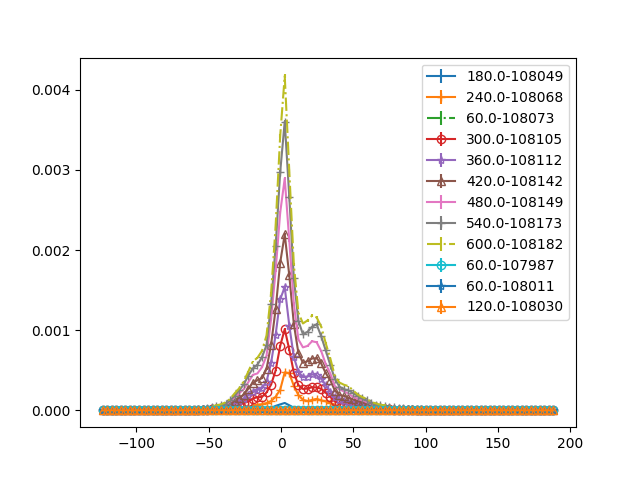

250.0 2 180.0
250.0 2 240.0
250.0 2 60.0
250.0 2 300.0
250.0 2 360.0
250.0 2 420.0
250.0 2 480.0
250.0 2 540.0
250.0 2 600.0
250.0 2 60.0
250.0 2 60.0
250.0 2 120.0


In [15]:
plt.figure()

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*', '^')) 

for RunNumber, record in data_table.items():
    Energy, Ei, \
        Chopper, Chopper1, Chopper2, Chopper3,\
        IE,\
        Q = record
        
    if Energy == 250. and Chopper == 2: # and Chopper2!=120.: # and Chopper2==180:
        print Energy, Chopper, Chopper2
        x,y,Err = IE
        x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
        # y_interp = np.interp(x_interp, x,y)
        y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

        # print Ei, Energy
        # plt.plot(x, y/np.sum(y), label=Chopper2)
        plt.errorbar(x,y, Err, fmt='-'+marker.next(), mfc='none', label='%s-%s' % (Chopper2, int(RunNumber)))
        # plt.plot(x_interp, y_interp2, 'o')
plt.legend()

<IPython.core.display.Javascript object>


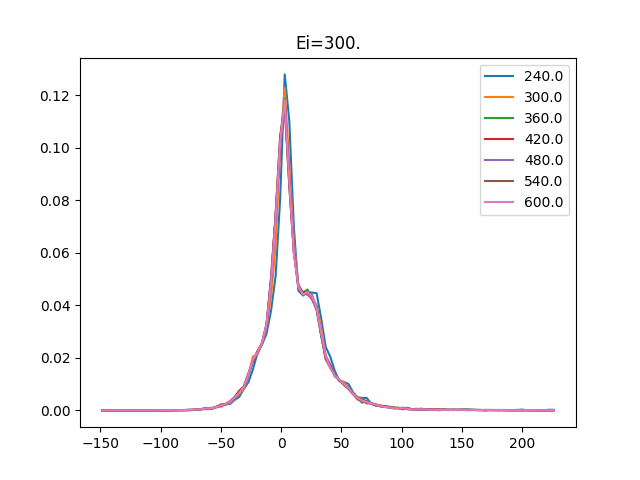

300.0 2 180.0
300.0 2 240.0
300.0 2 60.0
300.0 2 300.0
300.0 2 360.0
300.0 2 420.0
300.0 2 480.0
300.0 2 540.0
300.0 2 600.0
300.0 2 60.0
300.0 2 60.0
300.0 2 120.0


In [16]:
plt.figure()

for RunNumber, record in data_table.items():
    Energy, Ei, \
        Chopper, Chopper1, Chopper2, Chopper3,\
        IE,\
        Q = record
        
    if Energy == 300. and Chopper == 2: # and Chopper2!=120.: # and Chopper2==180:
        print Energy, Chopper, Chopper2
        if Chopper2 < 200: continue
        x,y,Err = IE
        x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
        # y_interp = np.interp(x_interp, x,y)
        y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

        # print Ei, Energy
        plt.plot(x, y/np.sum(y), label=Chopper2)
        # plt.plot(x_interp, y_interp2, 'o')
plt.title('Ei=300.')
plt.legend()

<IPython.core.display.Javascript object>


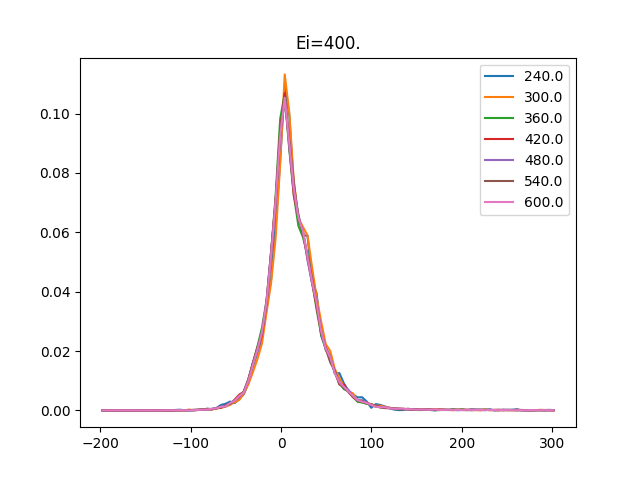

400.0 2 240.0
400.0 2 300.0
400.0 2 360.0
400.0 2 420.0
400.0 2 480.0
400.0 2 540.0
400.0 2 600.0


In [18]:
plt.figure()

for RunNumber, record in data_table.items():
    Energy, Ei, \
        Chopper, Chopper1, Chopper2, Chopper3,\
        IE,\
        Q = record
        
    if Energy == 400. and Chopper == 2: # and Chopper2!=120.: # and Chopper2==180:
        print Energy, Chopper, Chopper2
        x,y,Err = IE
        x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
        # y_interp = np.interp(x_interp, x,y)
        y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

        # print Ei, Energy
        plt.plot(x, y/np.sum(y), label=Chopper2)
        # plt.plot(x_interp, y_interp2, 'o')
plt.title('Ei=400.')
plt.legend()